## Data Setup Instructions

**Before running this notebook**, you need to download the required data files from Kaggle:

1. Go to: https://www.kaggle.com/competitions/playground-series-s4e7/data
2. Download `train.csv` and `test.csv`
3. Place them in the `./data/` directory

The notebook will not run without these files in place.

---

# Customer Response to Insurance Prediction

A Project by Anish Khanijaur (6480492) and Nathan Sakchiraphong (6480142)

**Note**: This notebook has been converted from Google Colab to run locally. Make sure you have downloaded the required data files as described above.

In [1]:
# Set device for XGBoost computation
device = 'cpu'
print(f"Using device: {device}")

Using device: cpu


## Problem Statement

Goal: The objective of this competition is to predict which customers respond positively to an automobile insurance offer.

Data: https://www.kaggle.com/competitions/playground-series-s4e7/data

**Note**: To run this notebook locally, you need to download the following files from the Kaggle competition and place them in the `./data/` directory:
- `train.csv`
- `test.csv`
- `sample_submission.csv` (already included)

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa
sns.set_style("darkgrid")


import xgboost as xgb

# Sklearn
from sklearn.metrics import precision_score, classification_report, make_scorer, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split


In [3]:
# Load the training data from local data directory
data_filepath = './data/'
train = pl.read_csv(data_filepath + 'train.csv')

In [4]:
train.describe()

statistic,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
str,f64,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64
"""count""",1.1504798e7,"""11504798""",1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,"""11504798""","""11504798""",1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0,0.0
"""mean""",5752398.5,null,38.383563,0.998022,26.41869,0.462997,null,null,30461.370411,112.425442,163.897744,0.122997
"""std""",3.3211e6,null,14.993459,0.044431,12.99159,0.498629,null,null,16454.745205,54.035708,79.979531,0.328434
"""min""",0.0,"""Female""",20.0,0.0,0.0,0.0,"""1-2 Year""","""No""",2630.0,1.0,10.0,0.0
"""25%""",2.876199e6,null,24.0,1.0,15.0,0.0,null,null,25277.0,29.0,99.0,0.0
"""50%""",5.752399e6,null,36.0,1.0,28.0,0.0,null,null,31824.0,151.0,166.0,0.0
"""75%""",8.628598e6,null,49.0,1.0,35.0,1.0,null,null,39451.0,152.0,232.0,0.0
"""max""",1.1504797e7,"""Male""",85.0,1.0,52.0,1.0,"""> 2 Years""","""Yes""",540165.0,163.0,299.0,1.0


In [5]:
train.head()

id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
i64,str,i64,i64,f64,i64,str,str,f64,f64,i64,i64
0,"""Male""",21,1,35.0,0,"""1-2 Year""","""Yes""",65101.0,124.0,187,0
1,"""Male""",43,1,28.0,0,"""> 2 Years""","""Yes""",58911.0,26.0,288,1
2,"""Female""",25,1,14.0,1,"""< 1 Year""","""No""",38043.0,152.0,254,0
3,"""Female""",35,1,1.0,0,"""1-2 Year""","""Yes""",2630.0,156.0,76,0
4,"""Female""",36,1,15.0,1,"""1-2 Year""","""No""",31951.0,152.0,294,0


Things that needed to be done at first glance.
- OHE : Gender, Region_Code, Vehicle_Age, Vehicle Damage, Policy Sales Channel
- Scaling Annual Premium

but Policy_Sales_Channel and Region_Code has so many unique values.

In [6]:
train["Response"].value_counts() #very imbalanced

Response,count
i64,u32
0,10089739
1,1415059


In [7]:
train.select([pl.col(pl.INTEGER_DTYPES), pl.col(pl.FLOAT_DTYPES)]).columns

['id',
 'Age',
 'Driving_License',
 'Previously_Insured',
 'Vintage',
 'Response',
 'Region_Code',
 'Annual_Premium',
 'Policy_Sales_Channel']

## EDA

In [8]:
numeric_cols = ["Age", "Vintage", "Annual_Premium", "Policy_Sales_Channel"]
sampled_train = train.sample(fraction=0.1)

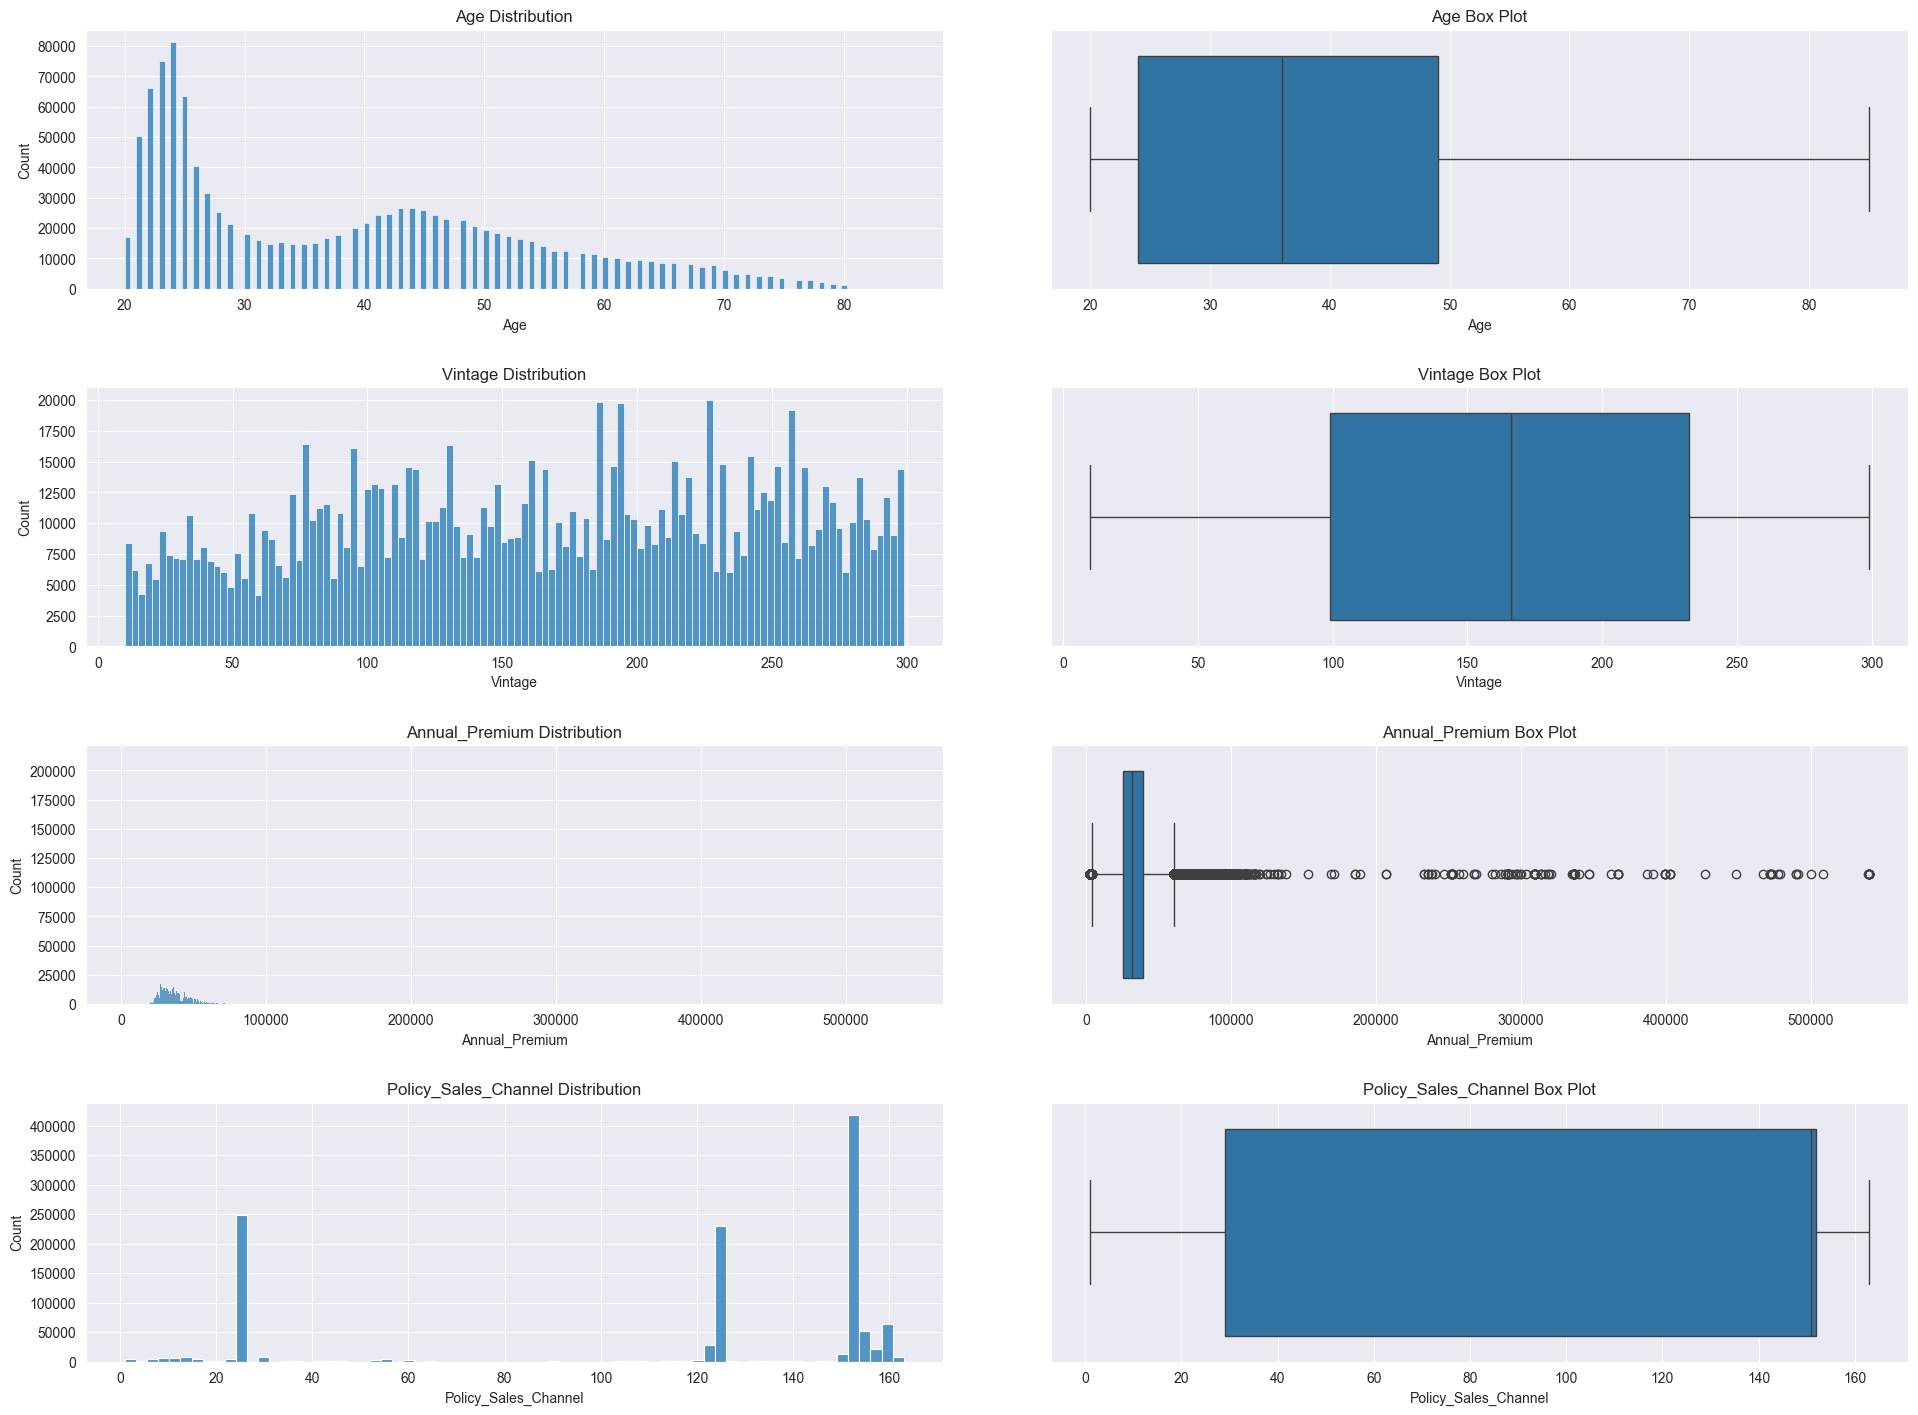

In [9]:
fig, ax = plt.subplots(4, 2, figsize=(20, 15))
fig.tight_layout(pad=5.0)
for i, col in enumerate(numeric_cols):
    # Histogram
    sns.histplot(data=sampled_train, x=col, ax=ax[i, 0])
    ax[i, 0].set_title(f'{col} Distribution')

    # Box plot
    sns.boxplot(data=sampled_train, x=col, ax=ax[i, 1])
    ax[i, 1].set_title(f'{col} Box Plot')
plt.show()

In [10]:
# train.columns
cat_cols = ["Gender", "Region_Code", "Vehicle_Age", "Vehicle_Damage", "Previously_Insured", "Driving_License"]

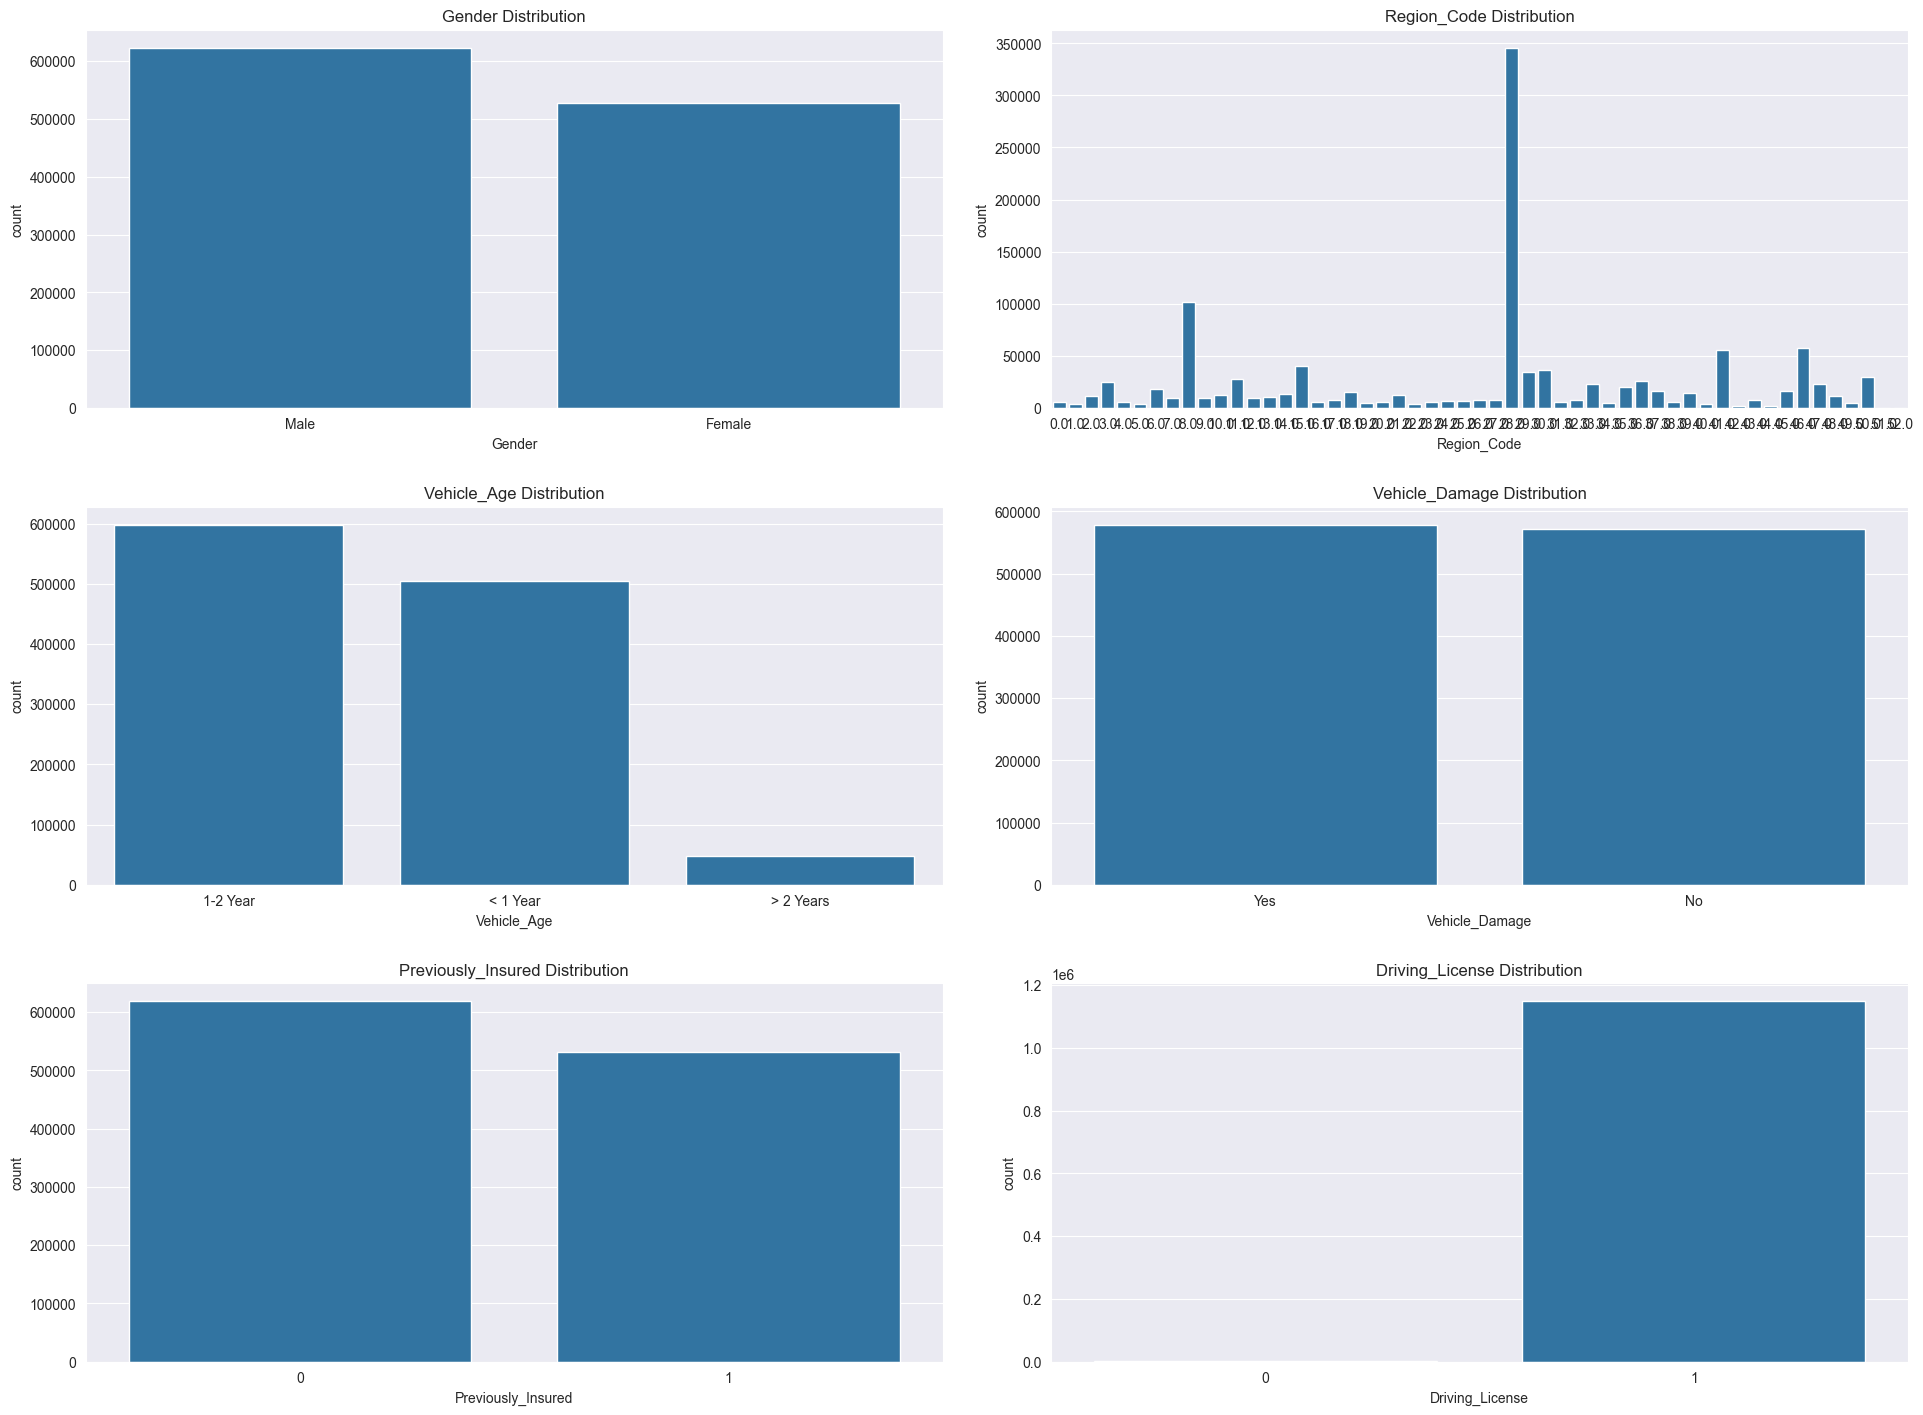

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
fig.tight_layout(pad=5.0)

for i, col in enumerate(cat_cols):
    row, col_num = divmod(i, 2)
    sns.countplot(data=sampled_train, x=col, ax=axs[row, col_num])
    axs[row, col_num].set_title(f'{col} Distribution')

plt.show()

In [12]:
# most of it is balanced, the driving license is almost 100% 1 tho.

In [13]:
train['Response'].value_counts()

Response,count
i64,u32
1,1415059
0,10089739


## Data Preprocessing

In [14]:
def preprocess(data):
    vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}

    # Casting columns to appropriate types, reduces memory usage
    data1 = data.with_columns(
        pl.col('Region_Code').cast(pl.UInt16),
        pl.col('Policy_Sales_Channel').cast(pl.UInt16),
        pl.col('Age').cast(pl.UInt16),
        pl.col('Response').cast(pl.UInt8),
        pl.col('Vintage').cast(pl.UInt16),
        pl.col('Previously_Insured').cast(pl.UInt8)
    )

    # Map categorical variables to numerical values
    data2 = data1.with_columns(
        pl.col("Gender").map_elements(lambda x: 1 if x == "Male" else 0, return_dtype=pl.UInt8),
        pl.col("Vehicle_Damage").map_elements(lambda x: 1 if x == "Yes" else 0, return_dtype=pl.UInt8),
        pl.col("Vehicle_Age").map_elements(lambda x: vehicle_age_mapping.get(x), return_dtype = pl.UInt8)
    )

    # Log transformation of Annual_Premium because of high outliers
    # This transformation helps to reduce skewness and stabilize variance
    # np.log1p is used to handle zero values gracefully
    data3 = data2.with_columns(
        pl.col("Annual_Premium").map_batches(lambda x: np.log1p(x), return_dtype=pl.Float64)
    )
    return data3

In [15]:
train2 = preprocess(train)
train.estimated_size(), train2.estimated_size()

(1006227160, 427115626)

In [16]:
train2.describe()

statistic,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",5752398.5,0.541351,38.383563,0.998022,26.41869,0.462997,0.603107,0.50268,9.997924,112.425442,163.897744,0.122997
"""std""",3.3211e6,0.498287,14.993459,0.044431,12.99159,0.498629,0.567856,0.499993,1.034031,54.035708,79.979531,0.328434
"""min""",0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,7.875119,1.0,10.0,0.0
"""25%""",2.876199e6,0.0,24.0,1.0,15.0,0.0,0.0,0.0,10.13769,29.0,99.0,0.0
"""50%""",5.752399e6,1.0,36.0,1.0,28.0,0.0,1.0,1.0,10.368007,151.0,166.0,0.0
"""75%""",8.628598e6,1.0,49.0,1.0,35.0,1.0,1.0,1.0,10.58284,152.0,232.0,0.0
"""max""",1.1504797e7,1.0,85.0,1.0,52.0,1.0,2.0,1.0,13.199632,163.0,299.0,1.0


At this point, "Policy_Sales_Chennel" and "Region_Code" are still categorical, we'll just consider them as numerical in the baseline model and will fix it afterwards.

In [17]:
train2['Policy_Sales_Channel'].n_unique(), train2['Region_Code'].n_unique()

(152, 53)

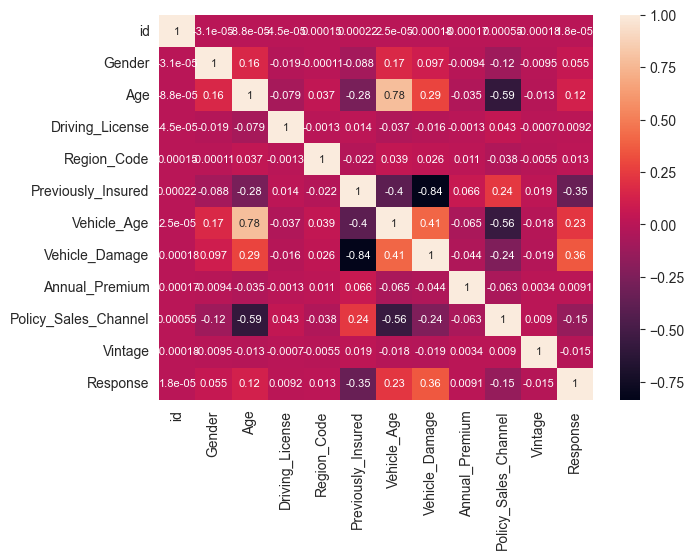

In [18]:
cor = train2.to_pandas().corr()
plt.figure(figsize=(7, 5))  # Increase the figure size
sns.heatmap(data=cor, annot=True, annot_kws={"size": 8})
plt.show()

In [19]:
def evaluate_model(model, X_train, x_test, y_train, y_test, fit="True", cm="True", eval_set=None):
  if fit:
      if eval_set:
        model.fit(X_train, y_train, eval_set=eval_set, verbose=0)
      else:
        model.fit(X_train, y_train)
  y_pred = model.predict(x_test)
  print(classification_report(y_test, y_pred))
  if cm:
    cm = confusion_matrix(y_test, y_pred) / len(y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
    disp.plot()
    plt.grid(False)
    plt.show()

In [20]:
X = train2.drop('Response').to_pandas()
y = train2['Response'].to_numpy()

X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

baseline_model = xgb.XGBClassifier(device=device)
# evaluate_model(baseline_model, X_train, x_test, y_train, y_test)

(8053358, 11) (3451440, 11) (8053358,) (3451440,)


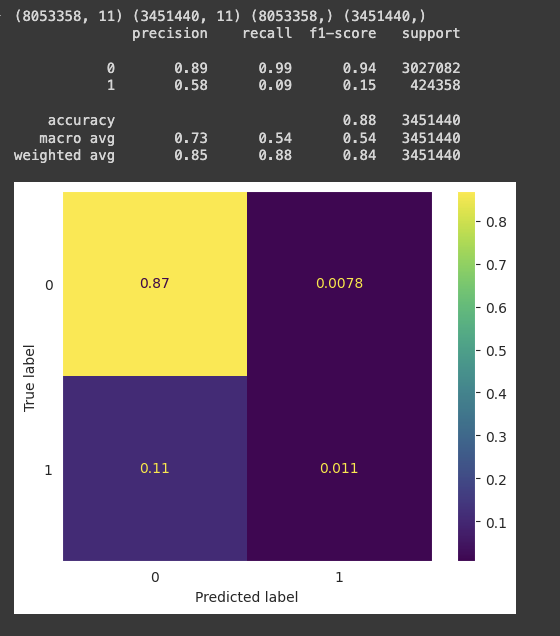


## Dealing with class imbalance

### 1. Undersampling

In [21]:
# creates an undersampled dataset with the ratio of 1
def undersample(ratio):
    negative_data = train2.filter(pl.col("Response") == 0)
    positive_data = train2.filter(pl.col("Response") == 1)
    negative_sample = negative_data.sample(n=ratio*len(positive_data))
    return pl.concat([negative_sample, positive_data])

In [22]:
# Undersampling with a ratio of i:1 where i = (1,4)

# for i in range(1, 5):
#     print(f"Undersampling with ratio {i}:1")
#     undersampled = undersample(i)
#     Xu = undersampled.drop('Response').to_pandas()
#     yu = undersampled['Response'].to_numpy()
#     Xu_train, xu_test, yu_train, yu_test = train_test_split(Xu, yu, test_size=0.3, random_state=42)
#     model = xgb.XGBClassifier(device=device)
#     print("Model performance on complete dataset")
#     evaluate_model(model, Xu_train, x_test, yu_train, y_test)

### 2. Class weights

In [23]:
# Trying out different predicition weights

# weights = [i for i in range(2, 12, 2)]
# for w in weights:
#   weighted_model = xgb.XGBClassifier(scale_pos_weight=w, device=device)
#   print("Model with pos_weight", w)
#   evaluate_model(weighted_model, X_train, x_test, y_train, y_test)

The actual ratio is about 8:1 we can see that giving weights that are equal to the imbalance yield the desired result in this case.

3. Combination

              precision    recall  f1-score   support

           0       0.99      0.69      0.81   3027082
           1       0.30      0.94      0.45    424358

    accuracy                           0.72   3451440
   macro avg       0.64      0.81      0.63   3451440
weighted avg       0.90      0.72      0.76   3451440



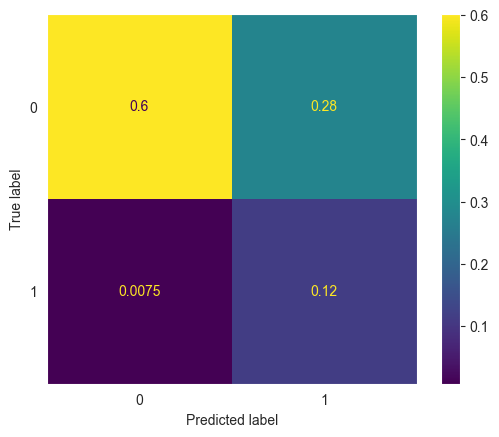

In [24]:
undersampled_df = undersample(1)
Xu = undersampled_df.drop('Response').to_pandas()
yu = undersampled_df['Response'].to_numpy()

Xu_train, xu_test, yu_train, yu_test = train_test_split(Xu, yu, test_size=0.3, random_state=42)
weighted_model2 = xgb.XGBClassifier(scale_pos_weight=1.1, device=device)
evaluate_model(weighted_model2, Xu_train, x_test, yu_train, y_test)

### Final config

Undersample sampling with ratio of 1:1 + makeing positive weight, 1.2.

#### Reasoning
Even though the f1_score is lower than some of the other configurations.
Recall measures how well our model performs in picking out True Positives and avoiding False positives. Now, we are building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company. This means that we want to see who is likely to take the insurance. Therefore, when our model produces a False Positive, it wouldn't hurt the insurance company in the slightest. This is because advertising is used by most insurance companies and getting advertised something that the customer might not be interested in will only cost the company the price of advertising to customers and marginally increasing the likelihood that customers will ignore future advertisements.

This means we need to do out best in finding customers who are potentially interested, or maximizing recall for class 1. However, this is coming from a profit first perspective which most companies have. If the goals of the company are somewhere else, such as maximizing customer satisfaction, a focus on recall would provide most beneficial as the customers who are unlikely to buy vehicular insurance won't be pestered by marketing maneuvers.

We feel that the concluding configuration gives us very good recall, 94% (identifying the correct potential customers) without bothering too many other people.

In [25]:
X_train = Xu_train.drop('id',axis=1).reset_index(drop=True)
x_test = x_test.drop('id',axis=1).reset_index(drop=True)
y_train = yu_train
undersampling_ratio = 1
pos_weight = 1.1

## Dealing with Categorical Columns

One-hot encoding doesn't need to be done here as XGBoost has a way to deal with categorical columns.

In [26]:
X_train['Region_Code'].nunique(), X_train['Policy_Sales_Channel'].nunique()

(53, 146)

After undersampling, we didn't lose any Region_Code data, but 8 Policy_Sales_Channels

              precision    recall  f1-score   support

           0       0.98      0.65      0.78   3027082
           1       0.26      0.88      0.41    424358

    accuracy                           0.68   3451440
   macro avg       0.62      0.77      0.59   3451440
weighted avg       0.89      0.68      0.74   3451440



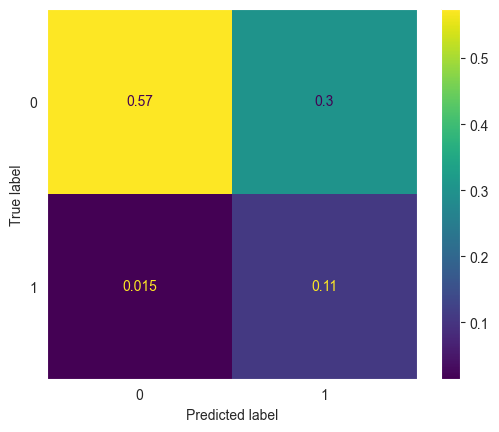

In [27]:
categorical_columns = ['Region_Code', 'Policy_Sales_Channel']
for col in categorical_columns:
    X_train[col] = X_train[col].astype('category')
    x_test[col] = x_test[col].astype('category')

# Baseline again, not messing with any other parameters to do with categorical values.
cat_model = xgb.XGBClassifier(scale_pos_weight=pos_weight, device=device, enable_categorical=True)
evaluate_model(cat_model, X_train, x_test, y_train, y_test)

A little drop compared to the previous model, we can try to tweak some categorical parameters further, or configure a cost function that asks XGBoost to prioritise certain metrics.

## Custom Cost for XGBoost using Confusion Matrix

In [28]:
def create_cost_function_cm(tp_weight, tn_weight, fp_weight, fn_weight):
  def cost_func(y_true, y_pred):
    y_pred = np.where(y_pred >= 0.5, 1, 0)
    cm = confusion_matrix(y_true, y_pred) / len(y_true)
    tp, tn, fp, fn = cm.ravel()
    weighted_score = -(tp_weight * tp + tn_weight * tn - fp_weight * fp - fn_weight * fn)
    return weighted_score
  return cost_func

In [29]:
# This runs forever, The important thing to note is that the it doesn't really improve the model over just undersampling+class-weight.

# params = {
#     'scale_pos_weight': pos_weight,
#     'device': device,
#     'enable_categorical': True,
#     'disable_default_eval_metric': 1,
#     'max_depth': 3,
#     'n_estimators': 50,
#     'early_stopping_rounds': 20,
#     'objective': 'binary:logistic',
# }
# tp_weight = 1.0
# tn_weight = 1.0
# fp_weight = 0.5
# # fn_weight = 0
# for fn_weight in np.linspace(1.4, 2.5, 5):
#   print(f"FN Weight {fn_weight}")
#   cost_func = create_cost_function_cm(tp_weight, tn_weight, fp_weight, fn_weight)
#   params['eval_metric'] = cost_func
#   custom_model = xgb.XGBClassifier(**params)
#   evaluate_model(custom_model, X_train, x_test, y_train, y_test, eval_set=[(x_test, y_test)])

There could be something more to be done with those categorical columns, however keeping them as categorical kind of ruin the model's performance that we want.

Another thing about the custom cost function is that, the depth, num_estimators and early stopping rounds needs to be configured lest it run forever.

We should stick with just the undersampled+class_weight model

## Custom Cost function using Precision and Recall.

In [30]:
def cost_func_pr(y_true, y_pred):
  y_pred = np.where(y_pred >= 0.5, 1, 0)
  report = classification_report(y_true, y_pred, output_dict=True)
  precision = report['0.0']['precision']
  recall = report['1.0']['recall']
  weighted_score = -(precision + recall)
  return weighted_score

In [31]:
# params = {
#     'scale_pos_weight': pos_weight,
#     'device': device,
#     'enable_categorical': True,
#     'disable_default_eval_metric': 1,
#     'objective': 'binary:logistic',
#     'eval_metric': cost_func_pr,
#     'max_depth': 4,
#     'n_estimators': 50,
#     'early_stopping_rounds': 20,
# }
# custom_model = xgb.XGBClassifier(**params)
# evaluate_model(custom_model, X_train, x_test, y_train, y_test, eval_set=[(x_test, y_test)])

Same story as the previous one it takes forever to run and doesn't yield any better results.

## Conclusion

Seeing as the undersampling+weighted class already has 0.94 recall on the '1' side and '0.99' precision on the '0' side when evaluated on the test set (3m+ datapoints), it is fair to say that using this model would reach 94% of potential customers that would respond positively to the offer as well as leaving alone 99% of customers that wouldn't be interested.

While it doesn't focus on accuracy/f1_score like a traditional model. We feel that this is a better fit for what the business would actually want.